This is Week 6 homework from [Winter 2020 of Statistical Rethinking](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework) using Python. A public repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python. It will helpful for me to do these exercises myself, but that repo will serve as a helpful reference.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit as logistic
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.optimize import curve_fit

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [4]:
os.getcwd()

'/Users/blacar/Documents/ds_projects/stats_rethinking/repo'

<IPython.core.display.Javascript object>

In [5]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# 11M4. Explain why the log link is appropriate for a Poisson generalized linear model

The log link ensures that lambda is always positive, which is what we'd expect for a count outcome. The other property of a log link is the exponential relationship between the predictors and expected value. Exponential relationships grow very quickly and few natural phenomena remain exponential for long. It is important to check whether a log link makes sense at all ranges of predictor variables. Priors on the log scale also scale in surprising ways. Prior predictive simulation is critical.

# 11M8. Revisit the `data(Kline)` islands example. This time drop Hawaii from the sample and refit the models. What changes do you observe?

## Data exploration

The first thing to do is make visualization so of the data. I will start by plotting "naively", such as plotting on both linear and log scales.

In [6]:
df_kline = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking_2/Data/Kline", sep=";"
)
df_kline["log_population"] = np.log(df_kline["population"])
df_kline

,culture,population,contact,total_tools,mean_TU,log_population
0,Malekula,1100,low,13,3.2,7.003065
1,Tikopia,1500,low,22,4.7,7.313220
2,Santa Cruz,3600,low,24,4.0,8.188689
3,Yap,4791,high,43,5.0,8.474494
4,Lau Fiji,7400,high,33,5.0,8.909235
5,Trobriand,8000,high,19,4.0,8.987197
6,Chuuk,9200,high,40,3.8,9.126959
7,Manus,13000,low,28,6.6,9.472705
8,Tonga,17500,high,55,5.4,9.769956
9,Hawaii,275000,low,71,6.6,12.524526


<IPython.core.display.Javascript object>

In [42]:
df_kline.shape

(10, 9)

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='log_population', ylabel='total_tools'>

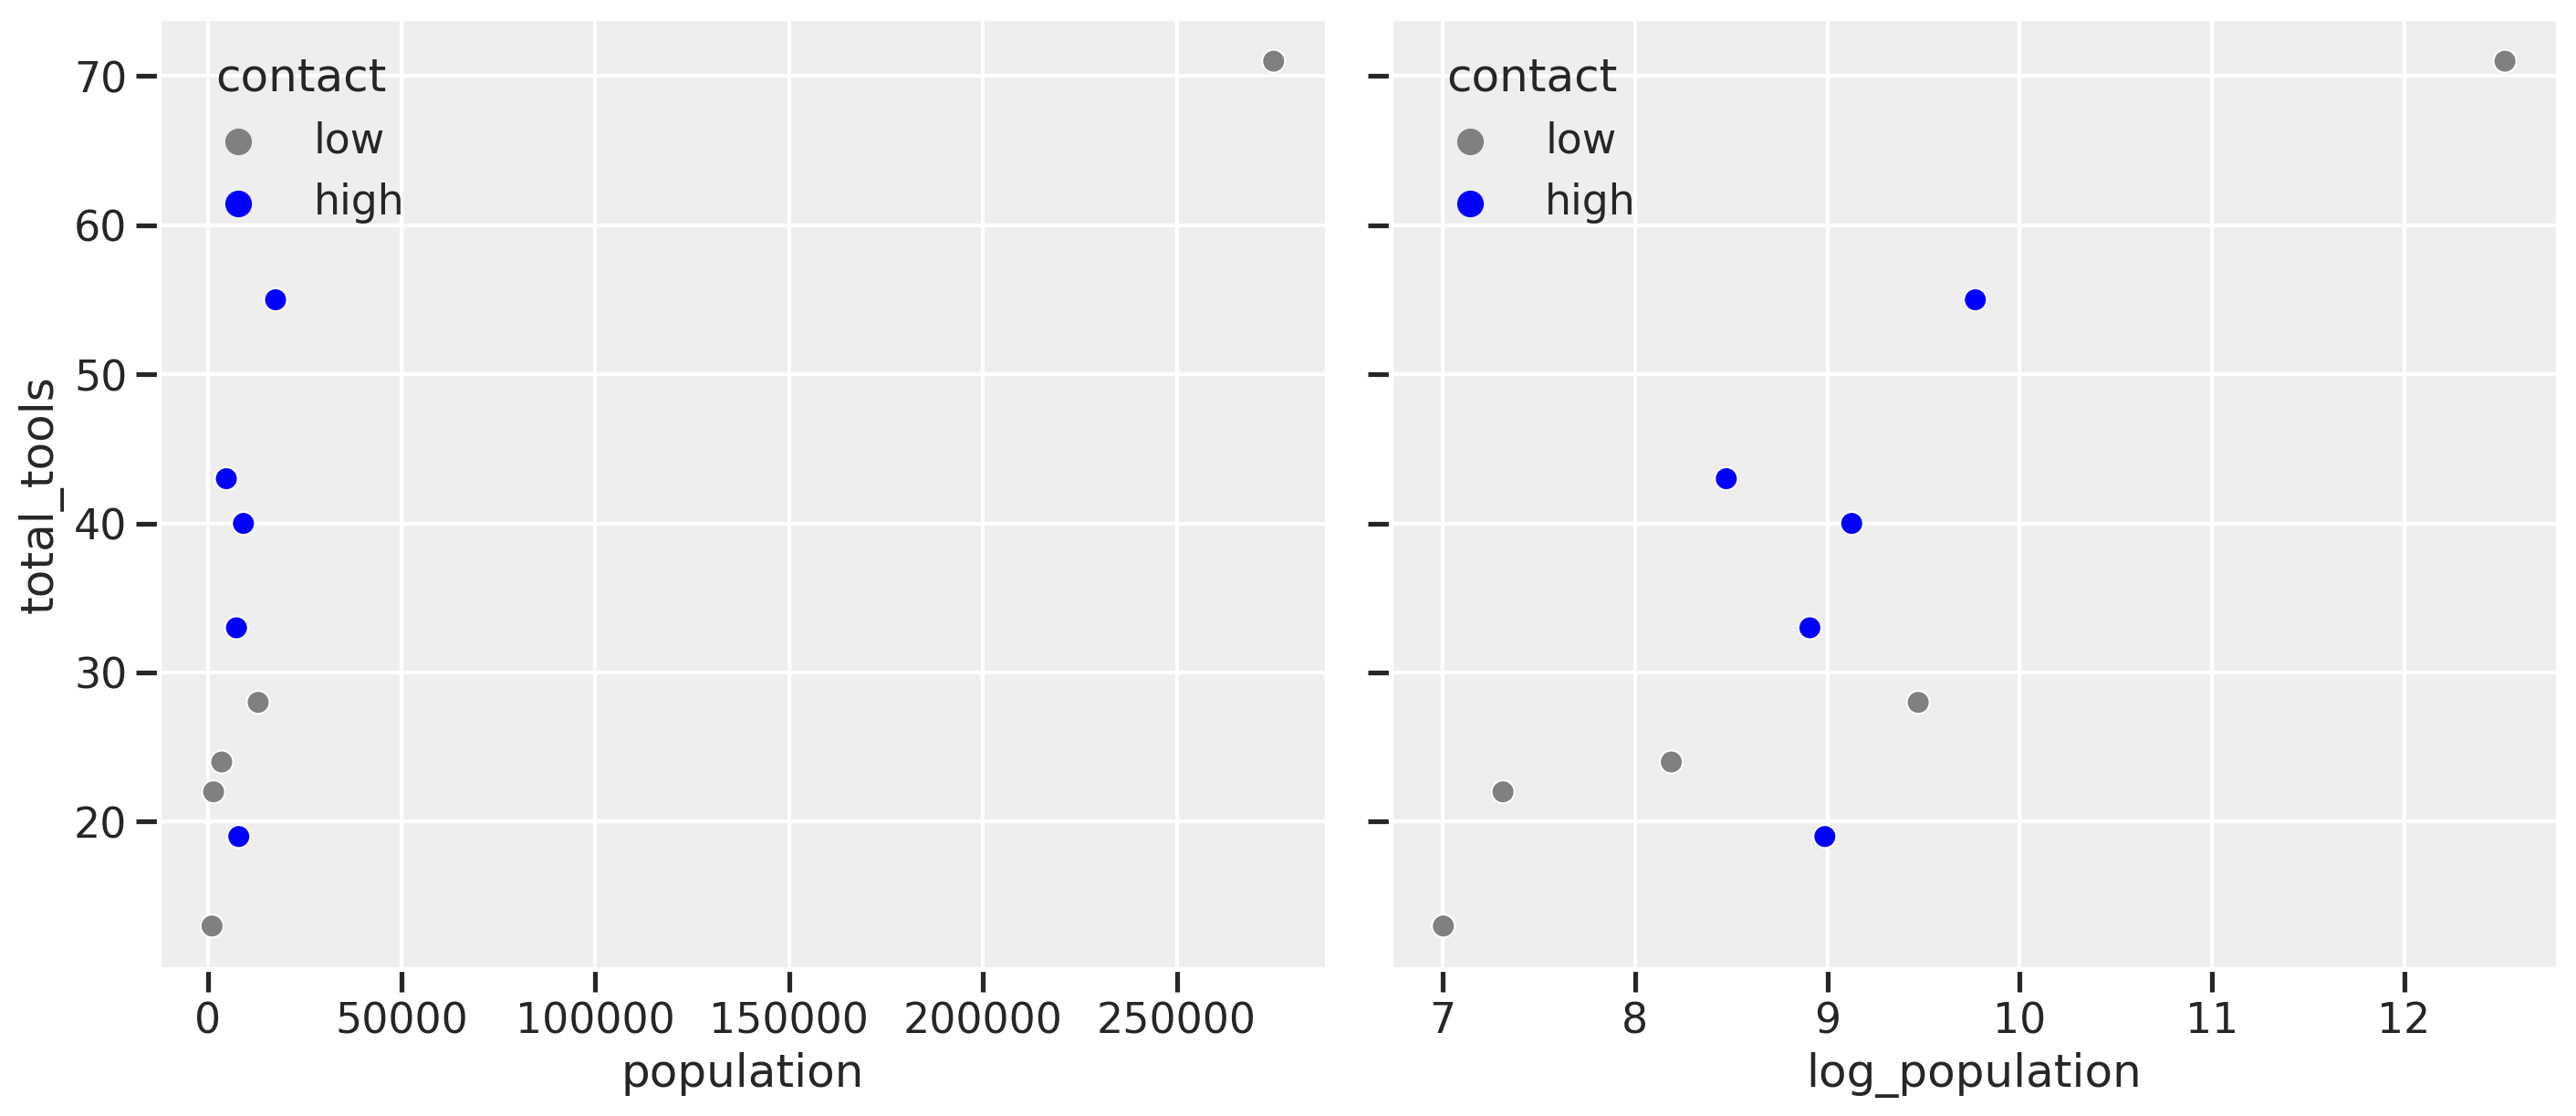

<IPython.core.display.Javascript object>

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.scatterplot(
    data=df_kline,
    x="population",
    y="total_tools",
    hue="contact",
    palette=["gray", "blue"],
    ax=ax1,
)
sns.scatterplot(
    data=df_kline,
    x="log_population",
    y="total_tools",
    hue="contact",
    palette=["gray", "blue"],
    ax=ax2,
)

If I were to keep going naively, I might stick with doing some kind of linear model on the right. But instead of moving forward with this, let's pivot to how it's done in the book.

## Create a poisson GLM model

Unlike binomial regression, the count of a poisson GLM has no known upper bound. Here, the number of trials *n* is very large and often unknown, and the probability of success *p* is very small. With *n* large and *p* small, the binomial distribution converges to a Poisson distribution that converges to an expected rate of events \(\lambda = np\). It is interesting to note that both the mean and the variance of a Poisson distribution is \(\lambda\).

The structure of the generalized linear model with a poisson likelihood takes the form:

$$y_i ∼ \text{Poisson}(\lambda_i) \tag{likelihood}$$
where \(y_i\) is a count. 

$$  \text{log}(\lambda_i) = \alpha + \beta x_i \tag{link function}$$    

The **log link** function can therefore be used to solve for the parameter \(\lambda_i\) :

$$  \lambda_i = {\text{exp}}(\alpha + \beta x_i) \tag{inverse link}$$

The above equations are general but let's re-write specfic to the problem, where we are trying to model the number of tools \(T-i\) and with `contact_id` (CID) as a categorical index variable.

$$T_i ∼ \text{Poisson}(\lambda_i)$$
$$  \text{log}(\lambda_i) = \alpha_{\text{CID}[i]} + \beta_{\text{CID}[i]}\text{log}P_i$$

I'll take advantage of what the book has already shown in determining the appropriate priors, but will take special note that priors are important to get sensible predictions.

$$\alpha ∼ \text{Normal}(3, 0.5)$$
$$\beta ∼ \text{Normal}(0, 0.2)$$

Note how \(\beta\) has to be particularly tight since larger priors can lead to explosive relationships. (This concern is lessened when there is more data but this is something to be cognizant of in the case of a small number of observations.)

### Prior predictions

In [136]:
N = 50
x_seq = np.linspace(np.log(100), np.log(200_000), N)
x_seq

array([ 4.60517019,  4.76029064,  4.9154111 ,  5.07053156,  5.22565202,
        5.38077248,  5.53589294,  5.69101339,  5.84613385,  6.00125431,
        6.15637477,  6.31149523,  6.46661569,  6.62173614,  6.7768566 ,
        6.93197706,  7.08709752,  7.24221798,  7.39733844,  7.55245889,
        7.70757935,  7.86269981,  8.01782027,  8.17294073,  8.32806119,
        8.48318164,  8.6383021 ,  8.79342256,  8.94854302,  9.10366348,
        9.25878394,  9.4139044 ,  9.56902485,  9.72414531,  9.87926577,
       10.03438623, 10.18950669, 10.34462715, 10.4997476 , 10.65486806,
       10.80998852, 10.96510898, 11.12022944, 11.2753499 , 11.43047035,
       11.58559081, 11.74071127, 11.89583173, 12.05095219, 12.20607265])

<IPython.core.display.Javascript object>

(0.0, 600.0)

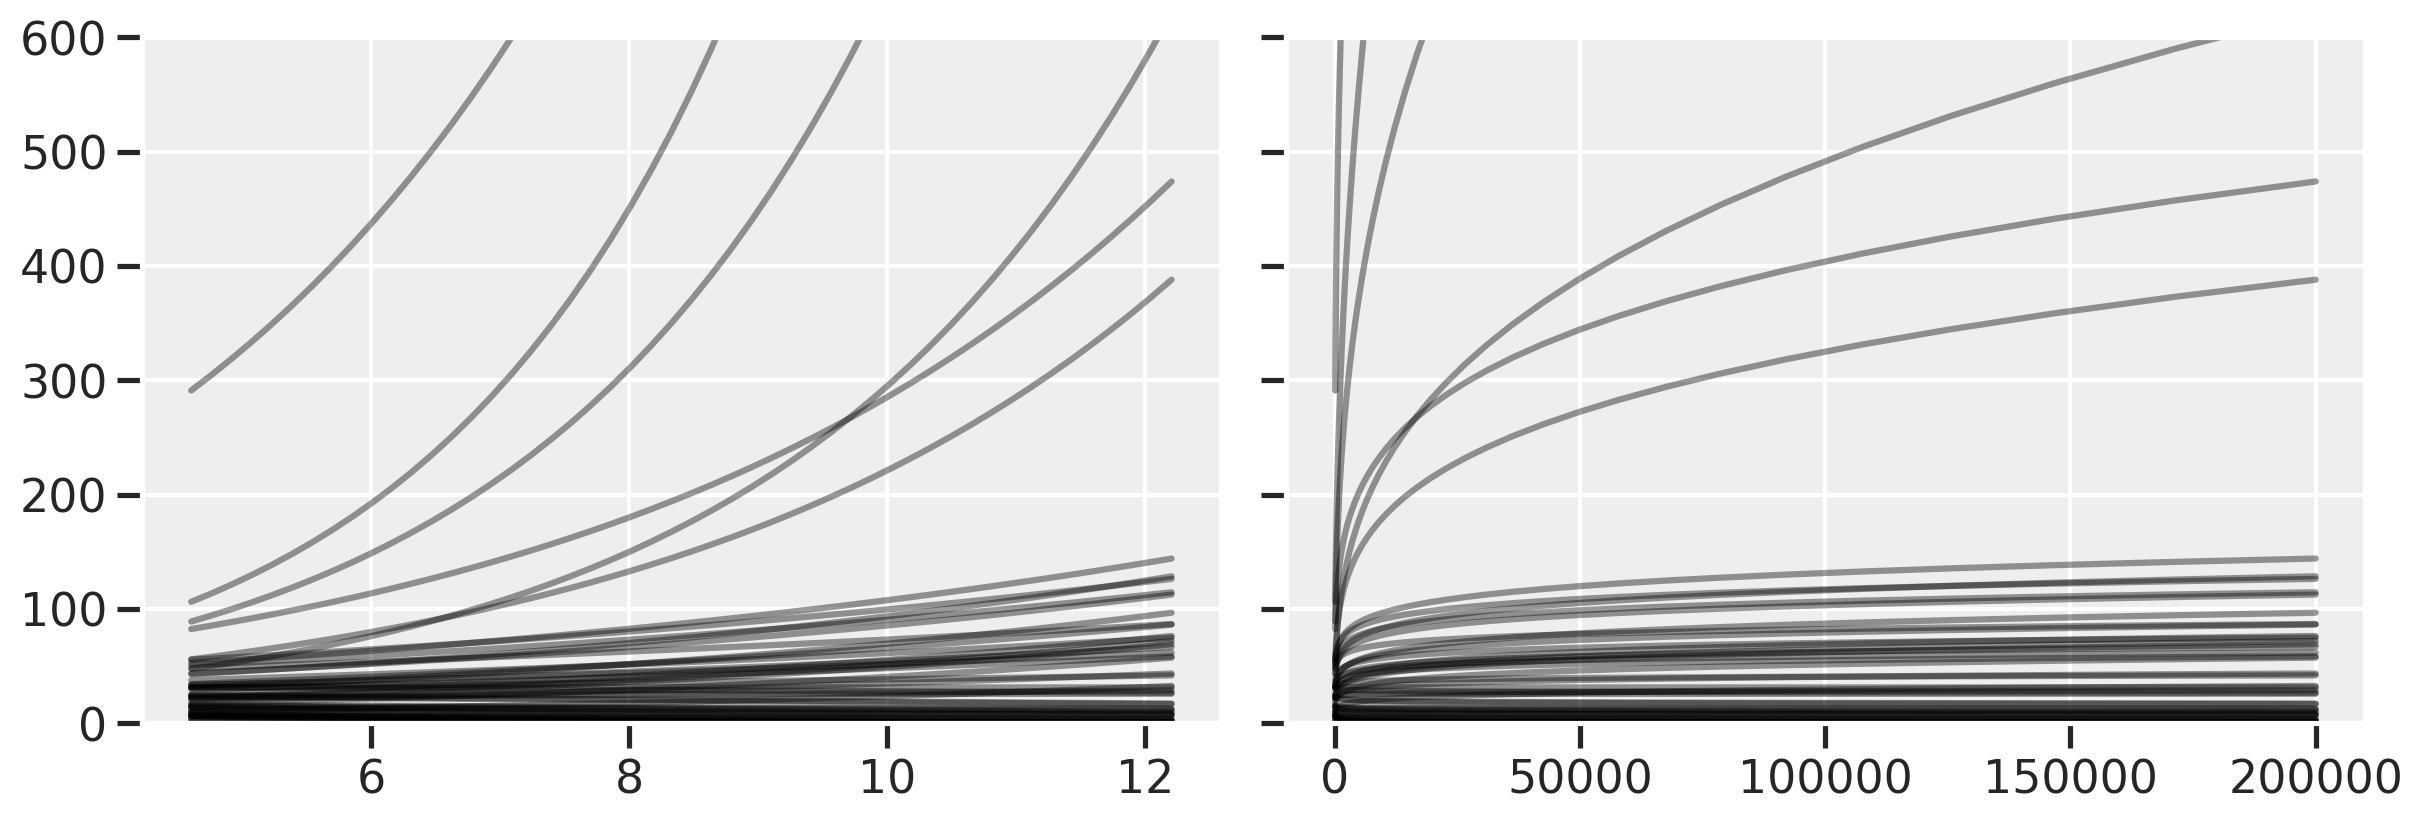

<IPython.core.display.Javascript object>

In [157]:
alphas = pm.Normal.dist(3, 0.5).random(size=N)
betas = pm.Normal.dist(0, 0.2).random(size=N)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for a, b in zip(alphas, betas):
    # Plot with xaxis (population) on log scale
    ax1.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
    # Plot with xaxis (population) on natural scale
    ax2.plot(np.exp(x_seq), np.exp(a + b * x_seq), "k", alpha=0.4)

# It's necessary to limit the y-axis for decent interpretability
ax1.set_ylim(0, 600)
ax1.set_ylabel("total tools")



(0.0, 500.0)

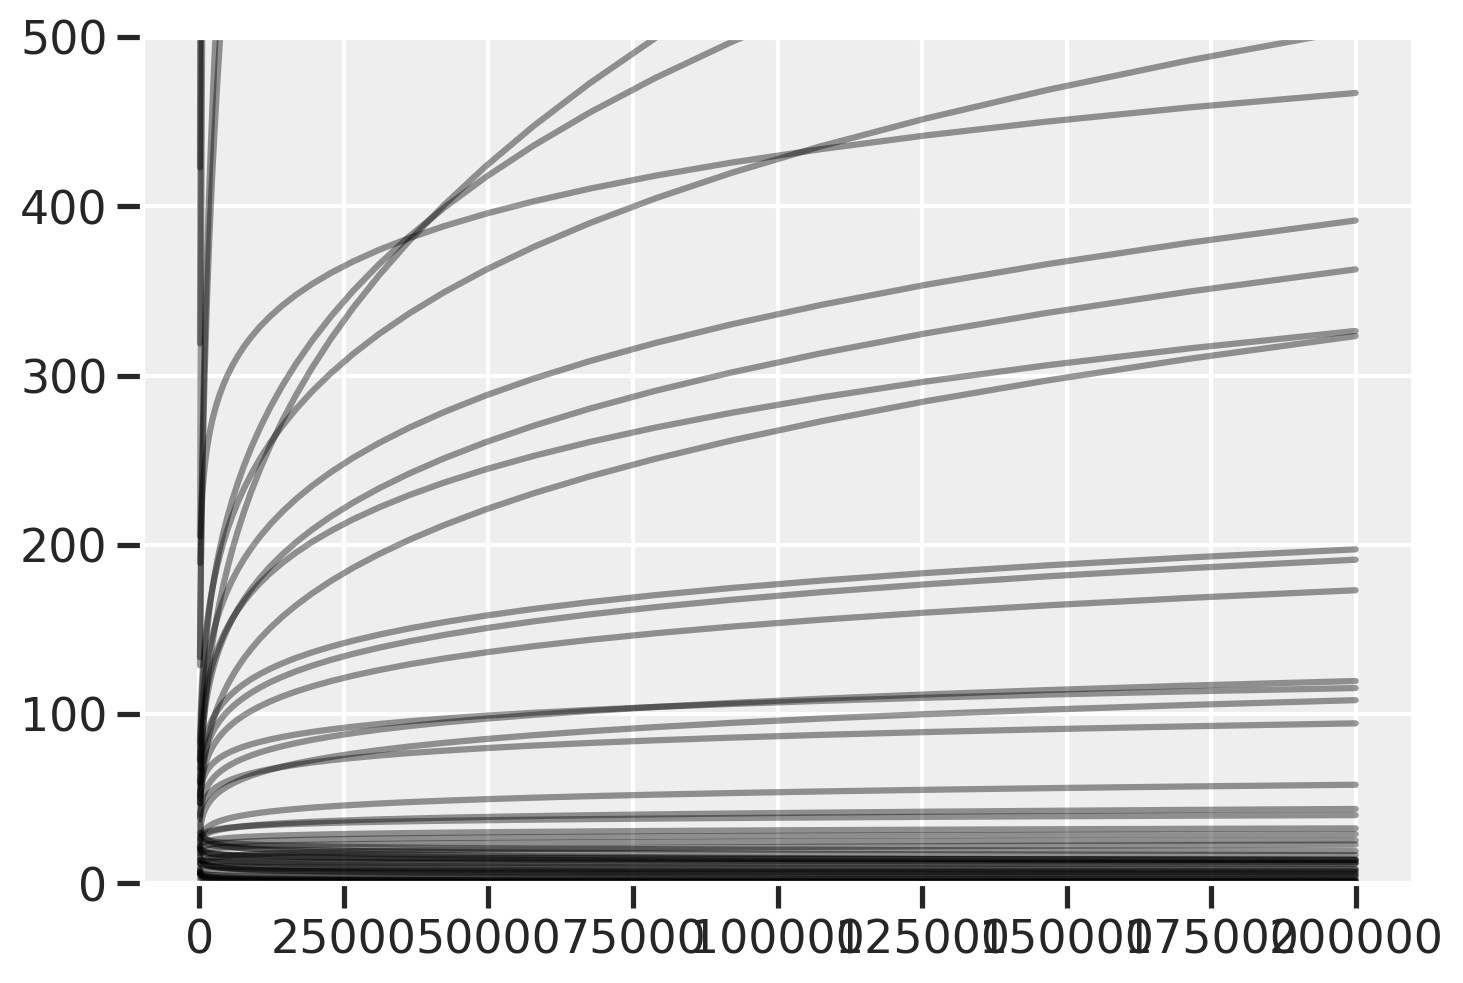

<IPython.core.display.Javascript object>

In [152]:

f, ax1 = plt.subplots()
for a, b in zip(alphas, betas):
    ax1.plot(np.exp(x_seq), np.exp(a + b * x_seq), "k", alpha=0.4)

ax1.set_ylim(0, 500)


In [ ]:
alphas = pm.Normal.dist(2, 1).random(size=N)
betas = pm.Normal.dist(0, 0.2).random(size=N)

f, ax1 = plt.subplots()
for a, b in zip(alphas, betas):
    ax1.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)

ax1.set_ylim(0, 500)


Now, let's prepare the dataframe for poisson GLM. We already have `log_population` but we need to standardize it and  add the `contact_id` index variable.

In [132]:
df_kline["log_population_std"] = standardize(df_kline["log_population"])
df_kline["contact_id"] = pd.Categorical(
    df_kline["contact"], categories=["low", "high"]
).codes  # Make "high" the higher index, like in the book

<IPython.core.display.Javascript object>

In [9]:
df_kline

,culture,population,contact,total_tools,mean_TU,log_population,log_population_std,contact_id
0,Malekula,1100,low,13,3.2,7.003065,-1.361332,0
1,Tikopia,1500,low,22,4.7,7.313220,-1.147433,0
2,Santa Cruz,3600,low,24,4.0,8.188689,-0.543664,0
3,Yap,4791,high,43,5.0,8.474494,-0.346558,1
4,Lau Fiji,7400,high,33,5.0,8.909235,-0.046737,1
5,Trobriand,8000,high,19,4.0,8.987197,0.007029,1
6,Chuuk,9200,high,40,3.8,9.126959,0.103416,1
7,Manus,13000,low,28,6.6,9.472705,0.341861,0
8,Tonga,17500,high,55,5.4,9.769956,0.546861,1
9,Hawaii,275000,low,71,6.6,12.524526,2.446558,0


<IPython.core.display.Javascript object>

In [131]:
df_kline["log_population_std"]

0   -1.361332
1   -1.147433
2   -0.543664
3   -0.346558
4   -0.046737
5    0.007029
6    0.103416
7    0.341861
8    0.546861
9    2.446558
Name: log_population_std, dtype: float64

<IPython.core.display.Javascript object>

In [10]:
with pm.Model() as m11_10:
    # Priors chosen from book lessons
    # shape=2 since we have contact rate index variable
    a = pm.Normal("a", 3, 0.5, shape=2)
    b = pm.Normal("b", 0, 0.2, shape=2)

    # The link function
    # Note how we use `pm.math.exp` to get lambda
    lam = pm.Deterministic(
        "lam",
        pm.math.exp(
            a[df_kline["contact_id"]]
            + b[df_kline["contact_id"]] * df_kline["log_population_std"]
        ),
    )

    # Likelihood,
    t = pm.Poisson("t", mu=lam, observed=df_kline["total_tools"])

    trace_m11_10 = pm.sample(
        1000, tune=1000, return_inferencedata=True
    )  # used arguments I've used before

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

In [11]:
trace_m11_10_df = trace_m11_10.to_dataframe()
trace_m11_10_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, b[0], 0)","(posterior, b[1], 1)","(posterior, lam[0], 0)","(posterior, lam[1], 1)","(posterior, lam[2], 2)","(posterior, lam[3], 3)",...,"(sample_stats, energy_error)","(sample_stats, energy)","(sample_stats, tree_size)","(sample_stats, lp)","(sample_stats, mean_tree_accept)","(sample_stats, step_size)","(sample_stats, perf_counter_diff)","(sample_stats, depth)","(sample_stats, diverging)","(sample_stats, max_energy_error)"
0,0,0,3.292982,3.695304,0.381365,-0.053377,16.019671,17.381234,21.881637,41.009450,...,0.069557,42.051738,3.0,-40.195923,0.750926,0.965043,0.000432,2,False,0.521316
1,0,1,3.360162,3.688175,0.393947,0.265857,16.841891,18.322581,23.242613,36.453586,...,0.056630,41.376216,3.0,-39.643606,0.901210,0.965043,0.000400,2,False,0.248181
2,0,2,3.231511,3.532377,0.356375,0.302329,15.585888,16.820429,20.858517,30.802701,...,-0.020513,40.565133,3.0,-39.805284,1.000000,0.965043,0.000495,2,False,-0.194189
3,0,3,3.293822,3.511150,0.352645,0.217026,16.672415,17.978669,22.244663,31.060549,...,-0.153621,40.075717,3.0,-39.416048,1.000000,0.965043,0.000524,2,False,-0.318921
4,0,4,3.273798,3.733761,0.289469,0.212957,17.809525,18.947096,22.565528,38.859755,...,0.835035,42.404279,3.0,-41.609869,0.757071,0.965043,0.000414,2,False,1.118288


<IPython.core.display.Javascript object>

In [12]:
trace_m11_10_df.columns

Index([                               'chain',
                                       'draw',
                     ('posterior', 'a[0]', 0),
                     ('posterior', 'a[1]', 1),
                     ('posterior', 'b[0]', 0),
                     ('posterior', 'b[1]', 1),
                   ('posterior', 'lam[0]', 0),
                   ('posterior', 'lam[1]', 1),
                   ('posterior', 'lam[2]', 2),
                   ('posterior', 'lam[3]', 3),
                   ('posterior', 'lam[4]', 4),
                   ('posterior', 'lam[5]', 5),
                   ('posterior', 'lam[6]', 6),
                   ('posterior', 'lam[7]', 7),
                   ('posterior', 'lam[8]', 8),
                   ('posterior', 'lam[9]', 9),
                ('log_likelihood', 't[0]', 0),
                ('log_likelihood', 't[1]', 1),
                ('log_likelihood', 't[2]', 2),
                ('log_likelihood', 't[3]', 3),
                ('log_likelihood', 't[4]', 4),
             

<IPython.core.display.Javascript object>

In [40]:
az.summary(trace_m11_10)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],3.317,0.089,3.187,3.469,0.001,0.001,4265.0,4265.0,4276.0,2953.0,1.0
a[1],3.610,0.072,3.496,3.725,0.001,0.001,5474.0,5474.0,5508.0,3392.0,1.0
b[0],0.362,0.050,0.280,0.435,0.001,0.001,4239.0,4176.0,4240.0,2992.0,1.0
b[1],0.195,0.154,-0.057,0.439,0.002,0.002,6282.0,4237.0,6256.0,3073.0,1.0
lam[0],17.000,2.252,13.294,20.402,0.036,0.026,3845.0,3845.0,3811.0,2785.0,1.0
lam[1],18.348,2.279,14.635,21.830,0.037,0.026,3863.0,3863.0,3832.0,2633.0,1.0
lam[2],22.775,2.351,18.998,26.441,0.037,0.026,3995.0,3995.0,3973.0,2876.0,1.0
lam[3],34.692,3.308,29.582,39.994,0.045,0.032,5386.0,5324.0,5373.0,3299.0,1.0
lam[4],36.711,2.678,32.175,40.613,0.036,0.026,5411.0,5374.0,5435.0,3309.0,1.0
lam[5],37.093,2.648,32.306,40.754,0.036,0.025,5491.0,5453.0,5518.0,3362.0,1.0


<IPython.core.display.Javascript object>

### Posterior predictions

In [13]:
with m11_10:
    ppc = pm.sample_posterior_predictive(trace_m11_10, random_seed=RANDOM_SEED)

<IPython.core.display.Javascript object>

In [14]:
ppc["t"].shape

(4000, 10)

<IPython.core.display.Javascript object>

In [15]:
ppc["t"].mean(axis=0)

array([16.99825, 18.43575, 22.71825, 34.75675, 36.76225, 37.004  ,
       37.762  , 31.36225, 41.29325, 67.3835 ])

<IPython.core.display.Javascript object>

#### Generate own link function

In [16]:
def get_link_pred(x, cid):
    """
    Mimic the link function of the rethinking package
    """
    if cid == 0:
        y = np.exp(
            trace_m11_10_df[("posterior", "a[0]", 0)]
            + trace_m11_10_df[("posterior", "b[0]", 0)] * x
        )
    elif cid == 1:
        y = np.exp(
            trace_m11_10_df[("posterior", "a[1]", 1)]
            + trace_m11_10_df[("posterior", "b[1]", 1)] * x
        )

    return y

<IPython.core.display.Javascript object>

In [17]:
np.zeros((100, 4000))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<IPython.core.display.Javascript object>

In [18]:
xseq = np.linspace(-5, 3, 100)

t_pred0 = np.zeros((len(xseq), len(trace_m11_10_df)))  # predictions for low contact
t_pred1 = np.zeros((len(xseq), len(trace_m11_10_df)))  # predictions for high contact

for i, x in enumerate(xseq):
    t_pred0[i] = get_link_pred(x, 0)
    t_pred1[i] = get_link_pred(x, 1)

df_t_pred0 = pd.DataFrame(t_pred0, index=xseq)
df_t_pred1 = pd.DataFrame(t_pred1, index=xseq)

print("low contact: ", df_t_pred0.head())

print("high contact: ", df_t_pred1.head())

low contact:                 0         1         2         3         4         5     \
-5.000000  3.999445  4.016565  4.261564  4.620941  6.211798  2.749436   
-4.919192  4.124617  4.146485  4.386072  4.754516  6.358814  2.852456   
-4.838384  4.253706  4.280609  4.514219  4.891952  6.509309  2.959336   
-4.757576  4.386835  4.419070  4.646109  5.033361  6.663366  3.070221   
-4.676768  4.524130  4.562010  4.781853  5.178858  6.821069  3.185261   

               6         7         8         9     ...      3990      3991  \
-5.000000  5.092222  3.051840  4.487839  7.051612  ...  4.368329  4.368329   
-4.919192  5.226140  3.158567  4.606096  7.216894  ...  4.500326  4.500326   
-4.838384  5.363581  3.269026  4.727468  7.386051  ...  4.636311  4.636311   
-4.757576  5.504636  3.383348  4.852039  7.559172  ...  4.776406  4.776406   
-4.676768  5.649401  3.501668  4.979892  7.736351  ...  4.920733  4.920733   

               3992      3993      3994      3995      3996      3997  \
-5.00

<IPython.core.display.Javascript object>

In [19]:
df_t_pred0.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
-5.000000,3.999445,4.016565,4.261564,4.620941,6.211798,2.749436,5.092222,3.051840,4.487839,7.051612,...,4.368329,4.368329,5.065112,6.475463,2.980989,5.604690,3.491743,4.074548,6.933651,2.916103
-4.919192,4.124617,4.146485,4.386072,4.754516,6.358814,2.852456,5.226140,3.158567,4.606096,7.216894,...,4.500326,4.500326,5.207317,6.632006,3.084777,5.759239,3.599927,4.203163,7.104340,3.017929
-4.838384,4.253706,4.280609,4.514219,4.891952,6.509309,2.959336,5.363581,3.269026,4.727468,7.386051,...,4.636311,4.636311,5.353515,6.792333,3.192178,5.918050,3.711462,4.335837,7.279230,3.123312
-4.757576,4.386835,4.419070,4.646109,5.033361,6.663366,3.070221,5.504636,3.383348,4.852039,7.559172,...,4.776406,4.776406,5.503817,6.956536,3.303318,6.081241,3.826453,4.472699,7.458426,3.232374
-4.676768,4.524130,4.562010,4.781853,5.178858,6.821069,3.185261,5.649401,3.501668,4.979892,7.736351,...,4.920733,4.920733,5.658339,7.124709,3.418328,6.248931,3.945007,4.613882,7.642033,3.345245


<IPython.core.display.Javascript object>

In [20]:
df_t_pred0["avg_tools"] = df_t_pred0.mean(axis=1)
df_t_pred1["avg_tools"] = df_t_pred1.mean(axis=1)

<IPython.core.display.Javascript object>

To create the natural scale (not standardized or logged), then reverse standardization and exponentiate.

In [21]:
log_pop_mean = np.mean(df_kline["log_population"])
log_pop_sd = np.std(df_kline["log_population"])
print(log_pop_mean, log_pop_sd)

8.977004744309943 1.4500053677448557


<IPython.core.display.Javascript object>

In [22]:
xseq_nat = np.exp(xseq * log_pop_sd + log_pop_mean)

<IPython.core.display.Javascript object>

In [23]:
# store pareto-k values for plot (taken from repo)
k = az.loo(trace_m11_10, pointwise=True).pareto_k.values

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<IPython.core.display.Javascript object>

In [24]:
df_kline["pareto_k"] = k
df_kline

,culture,population,contact,total_tools,mean_TU,log_population,log_population_std,contact_id,pareto_k
0,Malekula,1100,low,13,3.2,7.003065,-1.361332,0,0.499904
1,Tikopia,1500,low,22,4.7,7.313220,-1.147433,0,0.286665
2,Santa Cruz,3600,low,24,4.0,8.188689,-0.543664,0,0.304815
3,Yap,4791,high,43,5.0,8.474494,-0.346558,1,0.669062
4,Lau Fiji,7400,high,33,5.0,8.909235,-0.046737,1,0.351425
5,Trobriand,8000,high,19,4.0,8.987197,0.007029,1,0.664488
6,Chuuk,9200,high,40,3.8,9.126959,0.103416,1,0.028589
7,Manus,13000,low,28,6.6,9.472705,0.341861,0,0.214543
8,Tonga,17500,high,55,5.4,9.769956,0.546861,1,0.853956
9,Hawaii,275000,low,71,6.6,12.524526,2.446558,0,0.882281


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, s

(-25000.0, 300000.0)

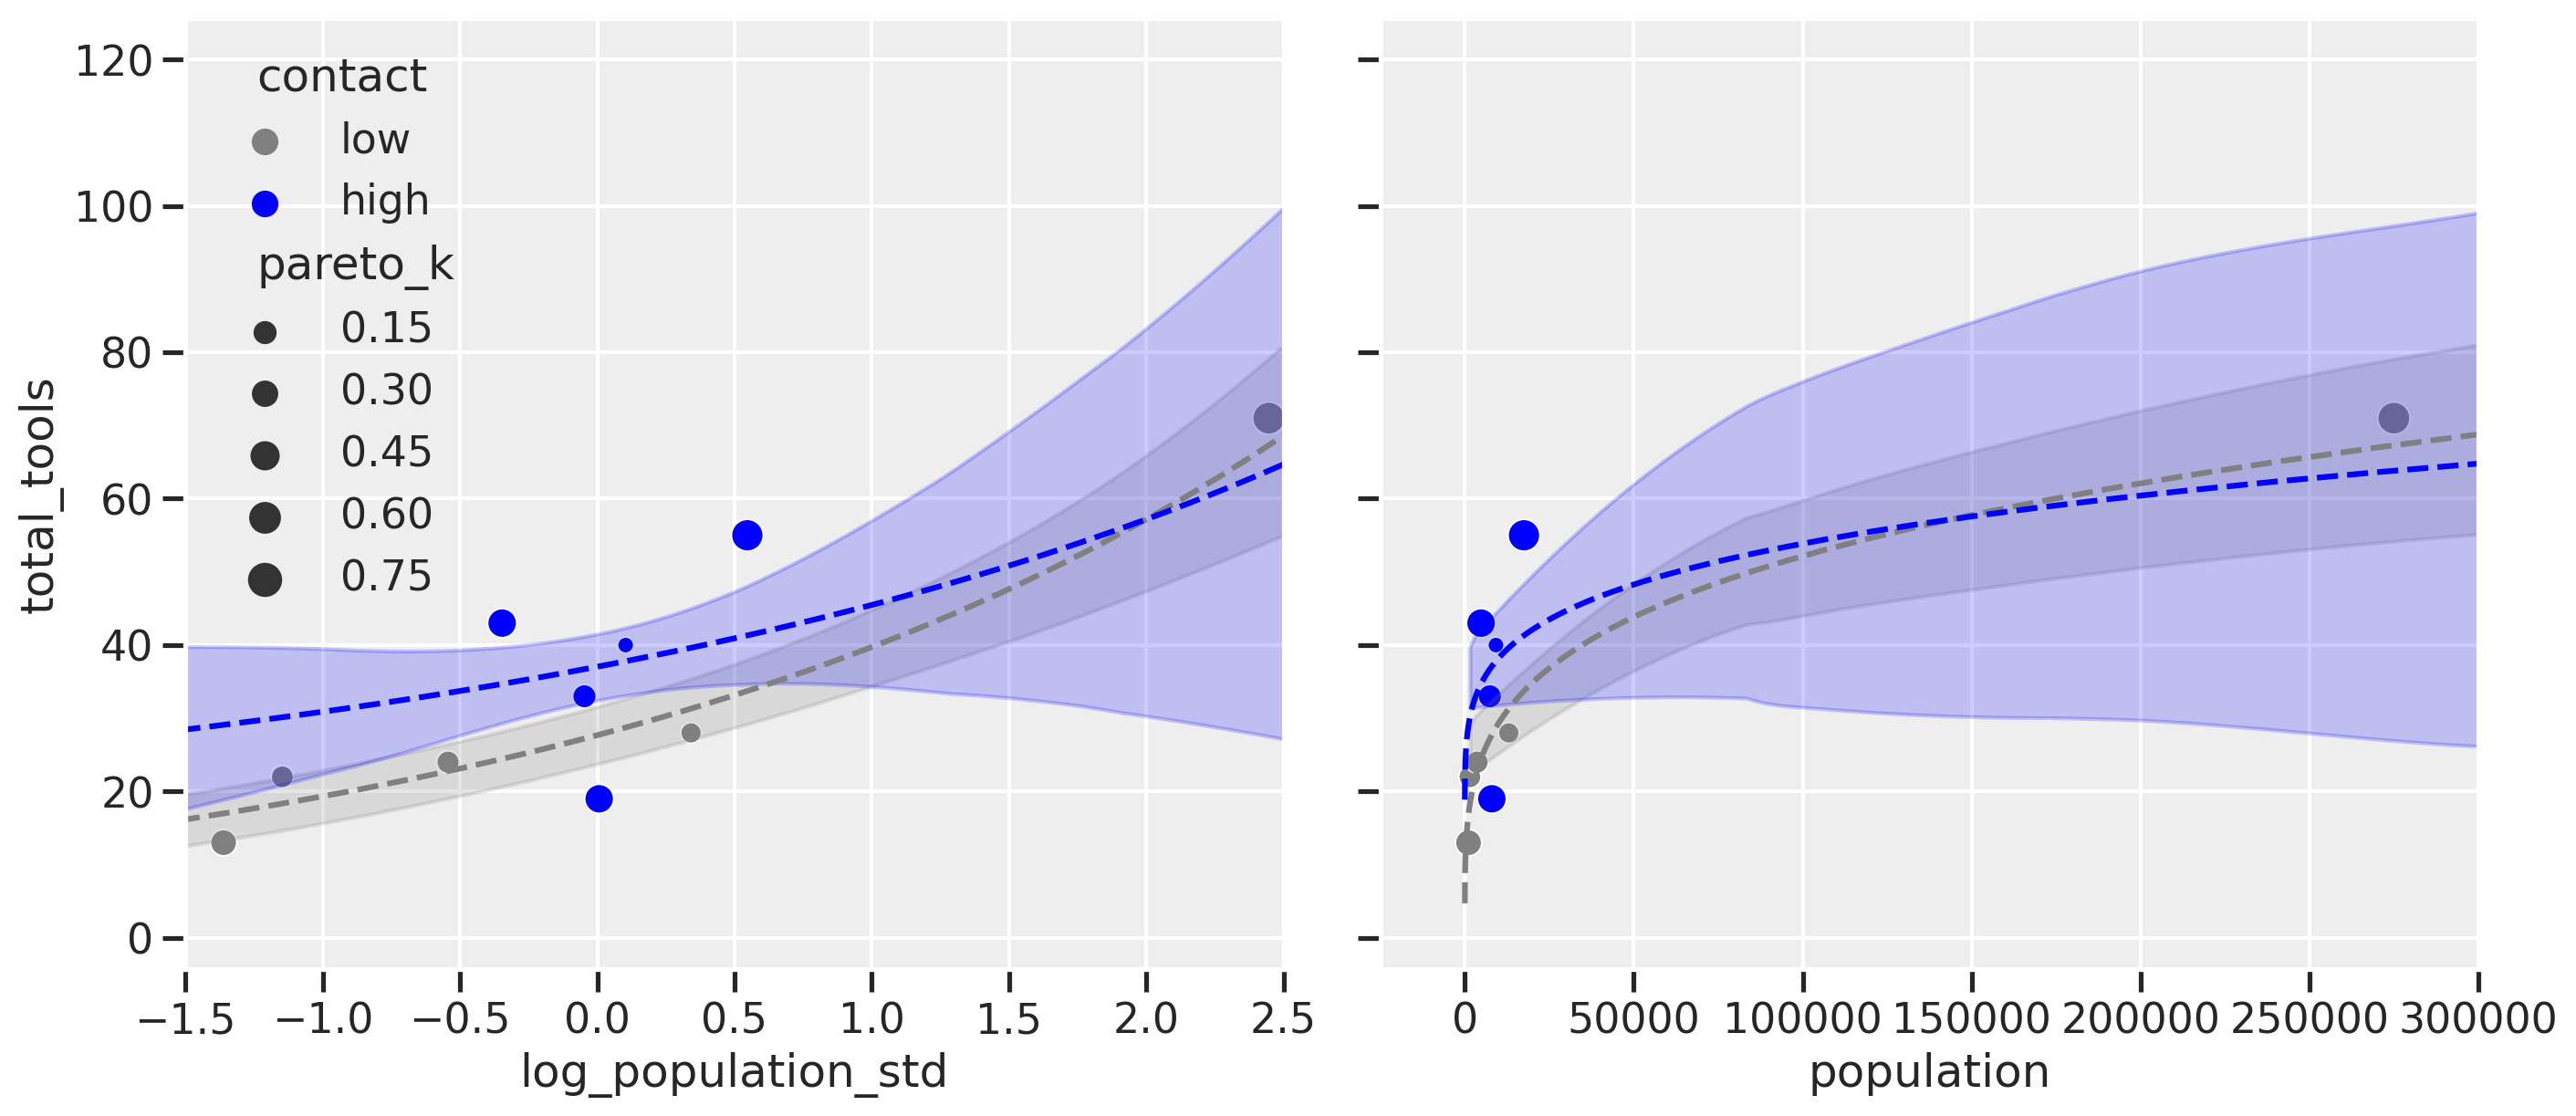

<IPython.core.display.Javascript object>

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Left subplot   -----------------------------------------
sns.scatterplot(
    data=df_kline,
    x="log_population_std",
    y="total_tools",
    hue="contact",
    palette=["gray", "blue"],
    size="pareto_k",
    ax=ax1,
)
ax1.plot(df_t_pred0.index, df_t_pred0["avg_tools"], linestyle="dashed", color="gray")
az.plot_hdi(
    df_t_pred0.index,
    df_t_pred0.iloc[:, 0:4000].T,
    ax=ax1,
    color="gray",
    fill_kwargs={"alpha": 0.2},
)

ax1.plot(df_t_pred1.index, df_t_pred1["avg_tools"], linestyle="dashed", color="blue")
az.plot_hdi(
    df_t_pred1.index,
    df_t_pred1.iloc[:, 0:4000].T,
    ax=ax1,
    color="blue",
    fill_kwargs={"alpha": 0.2},
)

ax1.set_xlim([-1.5, 2.5])

# Right subplot   -----------------------------------------
sns.scatterplot(
    data=df_kline,
    x="population",
    y="total_tools",
    hue="contact",
    palette=["gray", "blue"],
    size="pareto_k",
    legend=None,
    ax=ax2,
)
ax2.plot(xseq_nat, df_t_pred0["avg_tools"], linestyle="dashed", color="gray")
ax2.plot(xseq_nat, df_t_pred1["avg_tools"], linestyle="dashed", color="blue")

az.plot_hdi(
    xseq_nat,
    df_t_pred0.iloc[:, 0:4000].T,
    ax=ax2,
    color="gray",
    fill_kwargs={"alpha": 0.2},
)

az.plot_hdi(
    xseq_nat,
    df_t_pred1.iloc[:, 0:4000].T,
    ax=ax2,
    color="blue",
    fill_kwargs={"alpha": 0.2},
)

ax2.set_xlim([-25000, 300000])

## Drop Hawaii from dataset

In [26]:
# drop Hawaii and pareto_k since we should recalculate, recalculate log_population_std
df_kline_noH = df_kline.drop(9).drop("pareto_k", axis=1).copy()
df_kline_noH["log_population_std2"] = standardize(df_kline_noH["log_population"])
df_kline_noH

,culture,population,contact,total_tools,mean_TU,log_population,log_population_std,contact_id,log_population_std2
0,Malekula,1100,low,13,3.2,7.003065,-1.361332,0,-1.785951
1,Tikopia,1500,low,22,4.7,7.313220,-1.147433,0,-1.435317
2,Santa Cruz,3600,low,24,4.0,8.188689,-0.543664,0,-0.445588
3,Yap,4791,high,43,5.0,8.474494,-0.346558,1,-0.122481
4,Lau Fiji,7400,high,33,5.0,8.909235,-0.046737,1,0.368999
5,Trobriand,8000,high,19,4.0,8.987197,0.007029,1,0.457136
6,Chuuk,9200,high,40,3.8,9.126959,0.103416,1,0.615138
7,Manus,13000,low,28,6.6,9.472705,0.341861,0,1.006009
8,Tonga,17500,high,55,5.4,9.769956,0.546861,1,1.342055


<IPython.core.display.Javascript object>

In [27]:
with pm.Model() as m11_10b:
    # Priors chosen from book lessons
    # shape=2 since we have contact rate index variable
    a = pm.Normal("a", 3, 0.5, shape=2)
    b = pm.Normal("b", 0, 0.2, shape=2)

    # The link function
    # Note how we use `pm.math.exp` to get lambda
    lam = pm.Deterministic(
        "lam",
        pm.math.exp(
            a[df_kline_noH["contact_id"]]
            + b[df_kline_noH["contact_id"]] * df_kline_noH["log_population_std2"]
        ),
    )

    # Likelihood,
    t = pm.Poisson("t", mu=lam, observed=df_kline_noH["total_tools"])

    trace_m11_10b = pm.sample(
        1000, tune=1000, return_inferencedata=True
    )  # used arguments I've used before

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In [28]:
trace_m11_10b_df = trace_m11_10b.to_dataframe()

<IPython.core.display.Javascript object>

### Posterior predictions with own link function

In [29]:
# Irrelevant
with m11_10b:
    ppc2 = pm.sample_posterior_predictive(trace_m11_10b, random_seed=RANDOM_SEED)

<IPython.core.display.Javascript object>

In [30]:
xseq = np.linspace(-5, 3, 100)

t_predb0 = np.zeros((len(xseq), len(trace_m11_10b_df)))  # predictions for low contact
t_predb1 = np.zeros((len(xseq), len(trace_m11_10b_df)))  # predictions for high contact

for i, x in enumerate(xseq):
    t_predb0[i] = get_link_pred(x, 0)
    t_predb1[i] = get_link_pred(x, 1)

df_t_predb0 = pd.DataFrame(t_predb0, index=xseq)
df_t_predb1 = pd.DataFrame(t_predb1, index=xseq)

print("low contact: ", df_t_predb0.head())

print("high contact: ", df_t_predb1.head())

low contact:                 0         1         2         3         4         5     \
-5.000000  3.999445  4.016565  4.261564  4.620941  6.211798  2.749436   
-4.919192  4.124617  4.146485  4.386072  4.754516  6.358814  2.852456   
-4.838384  4.253706  4.280609  4.514219  4.891952  6.509309  2.959336   
-4.757576  4.386835  4.419070  4.646109  5.033361  6.663366  3.070221   
-4.676768  4.524130  4.562010  4.781853  5.178858  6.821069  3.185261   

               6         7         8         9     ...      3990      3991  \
-5.000000  5.092222  3.051840  4.487839  7.051612  ...  4.368329  4.368329   
-4.919192  5.226140  3.158567  4.606096  7.216894  ...  4.500326  4.500326   
-4.838384  5.363581  3.269026  4.727468  7.386051  ...  4.636311  4.636311   
-4.757576  5.504636  3.383348  4.852039  7.559172  ...  4.776406  4.776406   
-4.676768  5.649401  3.501668  4.979892  7.736351  ...  4.920733  4.920733   

               3992      3993      3994      3995      3996      3997  \
-5.00

<IPython.core.display.Javascript object>

In [31]:
df_t_predb0["avg_tools"] = df_t_predb0.mean(axis=1)
df_t_predb1["avg_tools"] = df_t_predb1.mean(axis=1)

<IPython.core.display.Javascript object>

To create the natural scale (not standardized or logged), then reverse standardization and exponentiate.

In [32]:
log_pop_mean2 = np.mean(df_kline_noH["log_population"])
log_pop_sd2 = np.std(df_kline_noH["log_population"])
print(log_pop_mean2, log_pop_sd2)

8.58283567405008 0.8845540388888837


<IPython.core.display.Javascript object>

In [33]:
xseq_nat2 = np.exp(xseq * log_pop_sd2 + log_pop_mean2)

<IPython.core.display.Javascript object>

In [34]:
# store pareto-k values for plot (taken from repo)
df_kline_noH["pareto_k2"] = az.loo(trace_m11_10b, pointwise=True).pareto_k.values
df_kline_noH

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,culture,population,contact,total_tools,mean_TU,log_population,log_population_std,contact_id,log_population_std2,pareto_k2
0,Malekula,1100,low,13,3.2,7.003065,-1.361332,0,-1.785951,0.466147
1,Tikopia,1500,low,22,4.7,7.313220,-1.147433,0,-1.435317,0.595843
2,Santa Cruz,3600,low,24,4.0,8.188689,-0.543664,0,-0.445588,0.439908
3,Yap,4791,high,43,5.0,8.474494,-0.346558,1,-0.122481,0.742015
4,Lau Fiji,7400,high,33,5.0,8.909235,-0.046737,1,0.368999,0.249740
5,Trobriand,8000,high,19,4.0,8.987197,0.007029,1,0.457136,0.628288
6,Chuuk,9200,high,40,3.8,9.126959,0.103416,1,0.615138,0.232152
7,Manus,13000,low,28,6.6,9.472705,0.341861,0,1.006009,0.684857
8,Tonga,17500,high,55,5.4,9.769956,0.546861,1,1.342055,0.898295


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, s

Text(0.5, 0.98, 'dropping Hawaii')

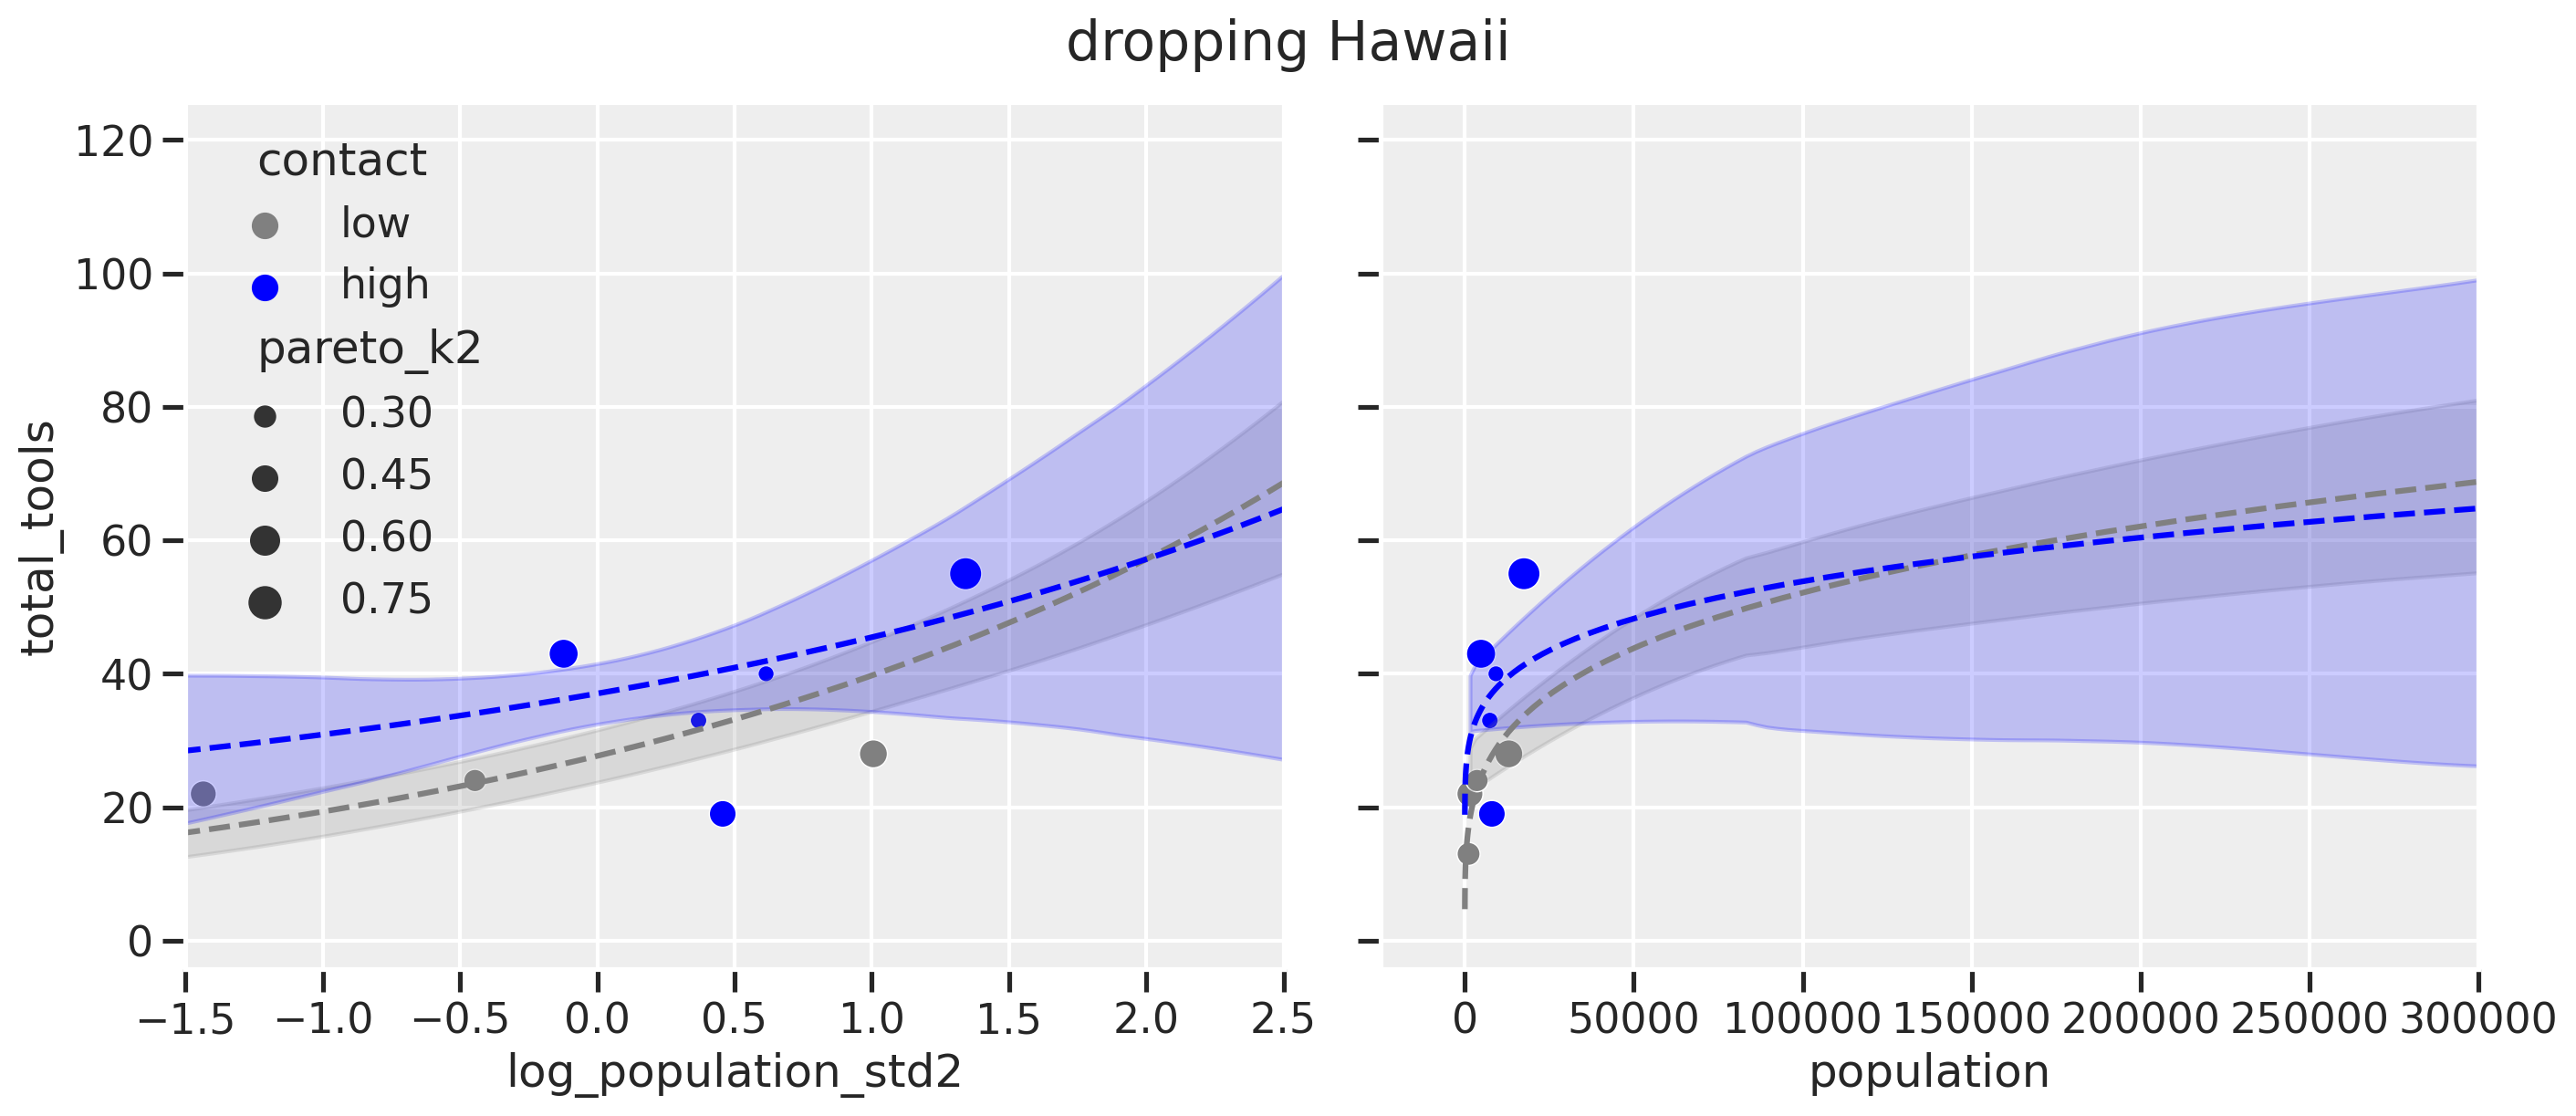

<IPython.core.display.Javascript object>

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Left subplot   -----------------------------------------
sns.scatterplot(
    data=df_kline_noH,
    x="log_population_std2",
    y="total_tools",
    hue="contact",
    palette=["gray", "blue"],
    size="pareto_k2",
    ax=ax1,
)
ax1.plot(df_t_predb0.index, df_t_predb0["avg_tools"], linestyle="dashed", color="gray")
az.plot_hdi(
    df_t_predb0.index,
    df_t_predb0.iloc[:, 0:4000].T,
    ax=ax1,
    color="gray",
    fill_kwargs={"alpha": 0.2},
)

ax1.plot(df_t_predb1.index, df_t_predb1["avg_tools"], linestyle="dashed", color="blue")
az.plot_hdi(
    df_t_predb1.index,
    df_t_predb1.iloc[:, 0:4000].T,
    ax=ax1,
    color="blue",
    fill_kwargs={"alpha": 0.2},
)

ax1.set_xlim([-1.5, 2.5])

# Right subplot   -----------------------------------------
sns.scatterplot(
    data=df_kline_noH,
    x="population",
    y="total_tools",
    hue="contact",
    palette=["gray", "blue"],
    size="pareto_k2",
    legend=None,
    ax=ax2,
)
ax2.plot(xseq_nat, df_t_predb0["avg_tools"], linestyle="dashed", color="gray")
ax2.plot(xseq_nat, df_t_predb1["avg_tools"], linestyle="dashed", color="blue")

az.plot_hdi(
    xseq_nat,
    df_t_predb0.iloc[:, 0:4000].T,
    ax=ax2,
    color="gray",
    fill_kwargs={"alpha": 0.2},
)

az.plot_hdi(
    xseq_nat,
    df_t_predb1.iloc[:, 0:4000].T,
    ax=ax2,
    color="blue",
    fill_kwargs={"alpha": 0.2},
)

ax2.set_xlim([-25000, 300000])

f.suptitle("dropping Hawaii")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, s

Text(0.5, 0.98, 'dropping Hawaii')

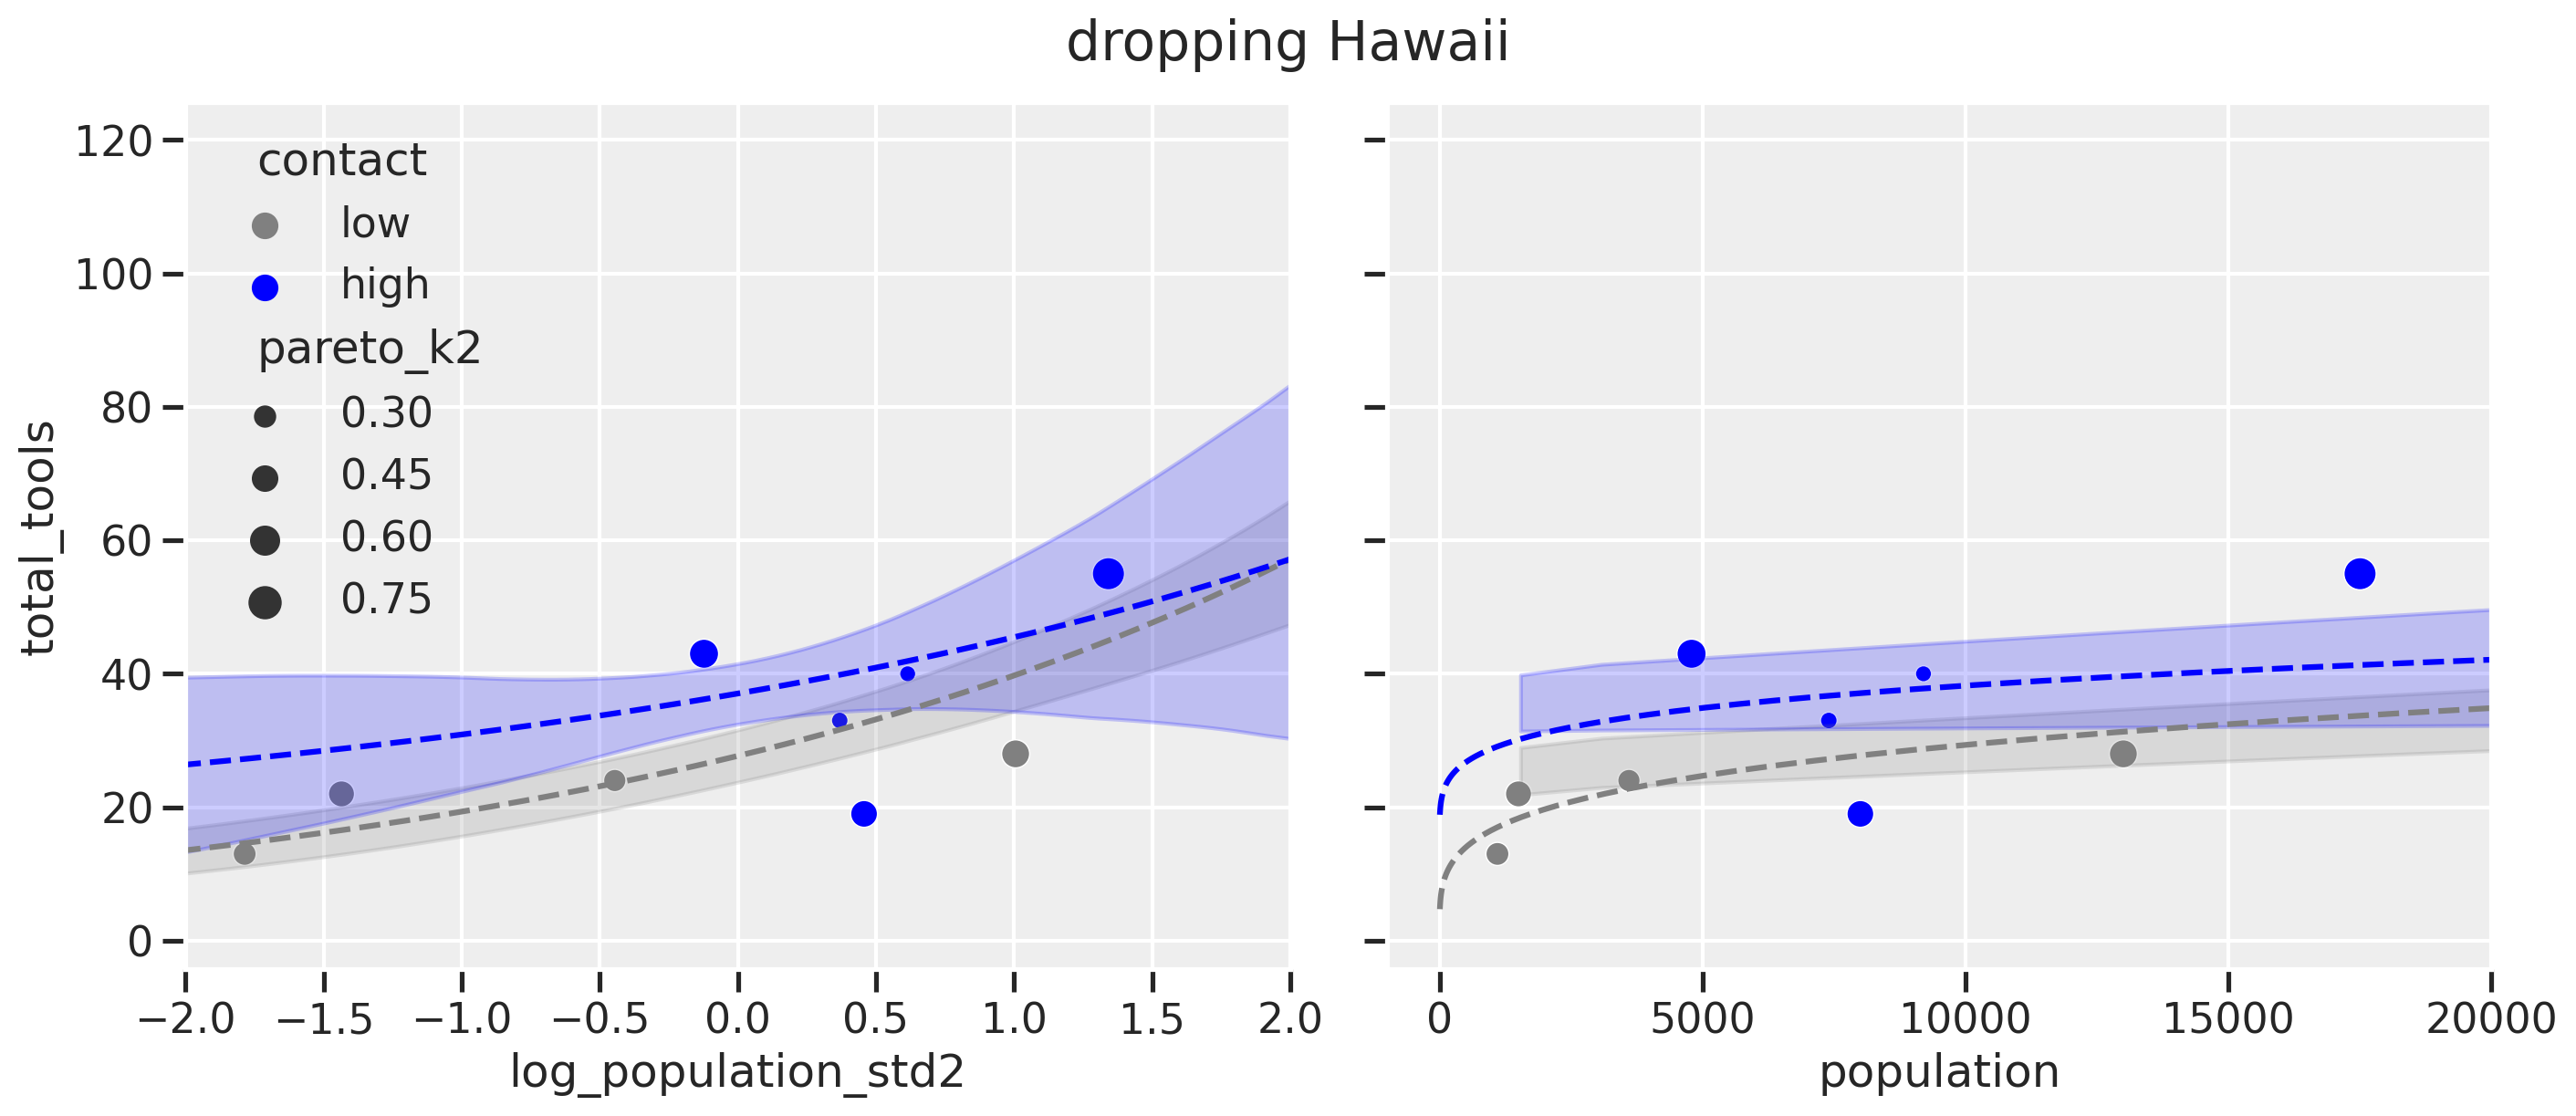

<IPython.core.display.Javascript object>

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Left subplot   -----------------------------------------
sns.scatterplot(
    data=df_kline_noH,
    x="log_population_std2",
    y="total_tools",
    hue="contact",
    palette=["gray", "blue"],
    size="pareto_k2",
    ax=ax1,
)
ax1.plot(df_t_predb0.index, df_t_predb0["avg_tools"], linestyle="dashed", color="gray")
az.plot_hdi(
    df_t_predb0.index,
    df_t_predb0.iloc[:, 0:4000].T,
    ax=ax1,
    color="gray",
    fill_kwargs={"alpha": 0.2},
)

ax1.plot(df_t_predb1.index, df_t_predb1["avg_tools"], linestyle="dashed", color="blue")
az.plot_hdi(
    df_t_predb1.index,
    df_t_predb1.iloc[:, 0:4000].T,
    ax=ax1,
    color="blue",
    fill_kwargs={"alpha": 0.2},
)

ax1.set_xlim([-2, 2])

# Right subplot   -----------------------------------------
sns.scatterplot(
    data=df_kline_noH,
    x="population",
    y="total_tools",
    hue="contact",
    palette=["gray", "blue"],
    size="pareto_k2",
    legend=None,
    ax=ax2,
)
ax2.plot(xseq_nat, df_t_predb0["avg_tools"], linestyle="dashed", color="gray")
ax2.plot(xseq_nat, df_t_predb1["avg_tools"], linestyle="dashed", color="blue")

az.plot_hdi(
    xseq_nat,
    df_t_predb0.iloc[:, 0:4000].T,
    ax=ax2,
    color="gray",
    fill_kwargs={"alpha": 0.2},
)

az.plot_hdi(
    xseq_nat,
    df_t_predb1.iloc[:, 0:4000].T,
    ax=ax2,
    color="blue",
    fill_kwargs={"alpha": 0.2},
)

ax2.set_xlim([-1000, 20000])

f.suptitle("dropping Hawaii")

### Summary

The high leverage point is now Tonga. The predictions make a little more sense since high contact predicts more tools consistently higher than low contact islands across the range of populations.

## Bonus: intercept with interaction

Intercept only but with interaction (low and high contact islands). This example was done to help me understand social notes data.

In [37]:
with pm.Model() as m11_9a:
    # Priors chosen from book lessons
    # shape=2 since we have contact rate index variable
    a = pm.Normal("a", 3, 0.5, shape=2)

    # The link function
    # Note how we use `pm.math.exp` to get lambda
    lam = pm.Deterministic("lam", pm.math.exp(a[df_kline["contact_id"]]))

    # Likelihood,
    t = pm.Poisson("t", mu=lam, observed=df_kline["total_tools"])

    trace_m11_9a = pm.sample(
        1000, tune=1000, return_inferencedata=True
    )  # used arguments I've used before

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In [38]:
trace_m11_9a_df = trace_m11_9a.to_dataframe()
trace_m11_9a_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, lam[0], 0)","(posterior, lam[1], 1)","(posterior, lam[2], 2)","(posterior, lam[3], 3)","(posterior, lam[4], 4)","(posterior, lam[5], 5)",...,"(sample_stats, energy_error)","(sample_stats, energy)","(sample_stats, tree_size)","(sample_stats, lp)","(sample_stats, mean_tree_accept)","(sample_stats, step_size)","(sample_stats, perf_counter_diff)","(sample_stats, depth)","(sample_stats, diverging)","(sample_stats, max_energy_error)"
0,0,0,3.388216,3.558984,29.613084,29.613084,29.613084,35.127480,35.127480,35.127480,...,0.117175,66.787318,3.0,-66.510728,0.888759,1.009132,0.000354,2,False,0.129586
1,0,1,3.296831,3.688692,27.026864,27.026864,27.026864,39.992516,39.992516,39.992516,...,0.585150,68.084724,3.0,-67.897459,0.780916,1.009132,0.000535,2,False,0.678102
2,0,2,3.317442,3.664141,27.589678,27.589678,27.589678,39.022603,39.022603,39.022603,...,-0.238489,68.152779,1.0,-67.229163,1.000000,1.009132,0.000366,1,False,-0.238489
3,0,3,3.144955,3.567788,23.218637,23.218637,23.218637,35.438113,35.438113,35.438113,...,2.096807,73.283527,3.0,-72.614551,0.908666,1.009132,0.000490,2,False,2.408830
4,0,4,3.561317,3.612430,35.209542,35.209542,35.209542,37.055972,37.055972,37.055972,...,-2.842777,71.068930,3.0,-67.084789,1.000000,1.009132,0.000371,2,False,-2.842777


<IPython.core.display.Javascript object>

In [43]:
df_kline.head()

,culture,population,contact,total_tools,mean_TU,log_population,log_population_std,contact_id,pareto_k
0,Malekula,1100,low,13,3.2,7.003065,-1.361332,0,0.499904
1,Tikopia,1500,low,22,4.7,7.313220,-1.147433,0,0.286665
2,Santa Cruz,3600,low,24,4.0,8.188689,-0.543664,0,0.304815
3,Yap,4791,high,43,5.0,8.474494,-0.346558,1,0.669062
4,Lau Fiji,7400,high,33,5.0,8.909235,-0.046737,1,0.351425


<IPython.core.display.Javascript object>

In [39]:
az.summary(trace_m11_9a)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],3.438,0.079,3.304,3.559,0.001,0.001,3163.0,3163.0,3178.0,2954.0,1.0
a[1],3.623,0.075,3.511,3.751,0.001,0.001,3517.0,3517.0,3522.0,2948.0,1.0
lam[0],31.227,2.453,27.202,35.108,0.044,0.031,3165.0,3158.0,3178.0,2954.0,1.0
lam[1],31.227,2.453,27.202,35.108,0.044,0.031,3165.0,3158.0,3178.0,2954.0,1.0
lam[2],31.227,2.453,27.202,35.108,0.044,0.031,3165.0,3158.0,3178.0,2954.0,1.0
lam[3],37.558,2.805,32.946,42.019,0.047,0.033,3523.0,3522.0,3522.0,2948.0,1.0
lam[4],37.558,2.805,32.946,42.019,0.047,0.033,3523.0,3522.0,3522.0,2948.0,1.0
lam[5],37.558,2.805,32.946,42.019,0.047,0.033,3523.0,3522.0,3522.0,2948.0,1.0
lam[6],37.558,2.805,32.946,42.019,0.047,0.033,3523.0,3522.0,3522.0,2948.0,1.0
lam[7],31.227,2.453,27.202,35.108,0.044,0.031,3165.0,3158.0,3178.0,2954.0,1.0


<IPython.core.display.Javascript object>

### Posterior predictions

In [59]:
def get_link_pred_intonly(cid):
    """
    Mimic the link function of the rethinking package.
    This won't have an x (population since we just care about
    contact rate here.)
    """
    if cid == 0:
        y = np.exp(trace_m11_9a_df[("posterior", "a[0]", 0)])
    elif cid == 1:
        y = np.exp(trace_m11_9a_df[("posterior", "a[1]", 1)])

    return y

<IPython.core.display.Javascript object>

In [61]:
get_link_pred_intonly(1)

0       35.127480
1       39.992516
2       39.022603
3       35.438113
4       37.055972
          ...    
3995    36.891432
3996    38.370723
3997    36.388529
3998    35.458052
3999    33.907840
Name: (posterior, a[1], 1), Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

In [65]:
type(len(trace_m11_9a_df))

int

<IPython.core.display.Javascript object>

In [72]:
# Mimics the number of tools, caring only about
# contact rates

t2_preds = np.zeros((2, len(trace_m11_9a_df)))  # predictions for low, high contact

t2_preds[0, :] = get_link_pred_intonly(0)
t2_preds[1, :] = get_link_pred_intonly(1)

df_t2_preds = pd.DataFrame(t2_preds)

<IPython.core.display.Javascript object>

In [73]:
df_t2_preds

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,29.613084,27.026864,27.589678,23.218637,35.209542,37.255012,30.458565,36.558626,32.203424,36.939977,...,31.557009,30.414842,31.568367,29.608803,26.186587,27.756010,35.035137,28.485792,30.991900,28.548163
1,35.127480,39.992516,39.022603,35.438113,37.055972,38.949466,36.467943,37.834247,39.129926,39.355043,...,34.889100,38.984956,35.385002,39.938383,39.794372,36.891432,38.370723,36.388529,35.458052,33.907840


<IPython.core.display.Javascript object>

In [77]:
df_t2_preds["avg_tools"] = df_t2_preds.mean(axis=1)

<IPython.core.display.Javascript object>

In [78]:
df_t2_preds

,0,1,2,3,4,5,6,7,8,9,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,avg_tools
0,29.613084,27.026864,27.589678,23.218637,35.209542,37.255012,30.458565,36.558626,32.203424,36.939977,...,30.414842,31.568367,29.608803,26.186587,27.756010,35.035137,28.485792,30.991900,28.548163,31.226703
1,35.127480,39.992516,39.022603,35.438113,37.055972,38.949466,36.467943,37.834247,39.129926,39.355043,...,38.984956,35.385002,39.938383,39.794372,36.891432,38.370723,36.388529,35.458052,33.907840,37.558208


<IPython.core.display.Javascript object>

To create the natural scale (not standardized or logged), then reverse standardization and exponentiate. (Done above)

In [21]:
log_pop_mean = np.mean(df_kline["log_population"])
log_pop_sd = np.std(df_kline["log_population"])
print(log_pop_mean, log_pop_sd)

8.977004744309943 1.4500053677448557


<IPython.core.display.Javascript object>

In [80]:
# for populations, not relevant here
# xseq_nat = np.exp(xseq * log_pop_sd + log_pop_mean)
# len(xseq_nat)

<IPython.core.display.Javascript object>

In [82]:
# store pareto-k values for plot (taken from repo)
k2 = az.loo(trace_m11_9a, pointwise=True).pareto_k.values

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<IPython.core.display.Javascript object>

In [83]:
df_kline["pareto_k2"] = k2
df_kline

,culture,population,contact,total_tools,mean_TU,log_population,log_population_std,contact_id,pareto_k,pareto_k2
0,Malekula,1100,low,13,3.2,7.003065,-1.361332,0,0.499904,0.517299
1,Tikopia,1500,low,22,4.7,7.313220,-1.147433,0,0.286665,0.335782
2,Santa Cruz,3600,low,24,4.0,8.188689,-0.543664,0,0.304815,0.300099
3,Yap,4791,high,43,5.0,8.474494,-0.346558,1,0.669062,0.231088
4,Lau Fiji,7400,high,33,5.0,8.909235,-0.046737,1,0.351425,0.427412
5,Trobriand,8000,high,19,4.0,8.987197,0.007029,1,0.664488,0.724311
6,Chuuk,9200,high,40,3.8,9.126959,0.103416,1,0.028589,0.176485
7,Manus,13000,low,28,6.6,9.472705,0.341861,0,0.214543,0.240608
8,Tonga,17500,high,55,5.4,9.769956,0.546861,1,0.853956,0.503596
9,Hawaii,275000,low,71,6.6,12.524526,2.446558,0,0.882281,1.677931


<IPython.core.display.Javascript object>

In [89]:
df_t2_preds

,0,1,2,3,4,5,6,7,8,9,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,avg_tools
0,29.613084,27.026864,27.589678,23.218637,35.209542,37.255012,30.458565,36.558626,32.203424,36.939977,...,30.414842,31.568367,29.608803,26.186587,27.756010,35.035137,28.485792,30.991900,28.548163,31.226703
1,35.127480,39.992516,39.022603,35.438113,37.055972,38.949466,36.467943,37.834247,39.129926,39.355043,...,38.984956,35.385002,39.938383,39.794372,36.891432,38.370723,36.388529,35.458052,33.907840,37.558208


<IPython.core.display.Javascript object>

In [94]:
az.hdi(np.array(df_t2_preds.loc[0, :]))

array([27.21145794, 35.10835293])

<IPython.core.display.Javascript object>

In [95]:
az.hdi(np.array(df_t2_preds.loc[1, :]))

array([33.4893344 , 42.55608744])

<IPython.core.display.Javascript object>

In [104]:
df_t2_preds.index.shape

(2,)

<IPython.core.display.Javascript object>

In [105]:
df_t2_preds.iloc[0, 0:4000].T.shape

(4000,)

<IPython.core.display.Javascript object>

In [111]:
df_t_pred0.index

,0,1,2,3,4,5,6,7,8,9,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,avg_tools
-5.000000,3.999445,4.016565,4.261564,4.620941,6.211798,2.749436,5.092222,3.051840,4.487839,7.051612,...,4.368329,5.065112,6.475463,2.980989,5.604690,3.491743,4.074548,6.933651,2.916103,4.718558
-4.919192,4.124617,4.146485,4.386072,4.754516,6.358814,2.852456,5.226140,3.158567,4.606096,7.216894,...,4.500326,5.207317,6.632006,3.084777,5.759239,3.599927,4.203163,7.104340,3.017929,4.853093
-4.838384,4.253706,4.280609,4.514219,4.891952,6.509309,2.959336,5.363581,3.269026,4.727468,7.386051,...,4.636311,5.353515,6.792333,3.192178,5.918050,3.711462,4.335837,7.279230,3.123312,4.991543
-4.757576,4.386835,4.419070,4.646109,5.033361,6.663366,3.070221,5.504636,3.383348,4.852039,7.559172,...,4.776406,5.503817,6.956536,3.303318,6.081241,3.826453,4.472699,7.458426,3.232374,5.134026
-4.676768,4.524130,4.562010,4.781853,5.178858,6.821069,3.185261,5.649401,3.501668,4.979892,7.736351,...,4.920733,5.658339,7.124709,3.418328,6.248931,3.945007,4.613882,7.642033,3.345245,5.280659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.676768,74.724555,82.654298,65.722627,69.253286,57.319446,90.552630,59.967445,79.937452,53.103752,63.704729,...,73.881198,70.301163,62.633784,76.980160,74.274064,63.375713,78.031768,69.875799,76.015216,73.217057
2.757576,77.063223,85.327853,67.642822,71.255153,58.676036,93.945592,61.544510,82.732968,54.503058,65.197899,...,76.113649,72.274899,64.147943,79.660341,76.322172,65.339263,80.494870,71.595960,78.669579,75.418760
2.838384,79.475084,88.087887,69.619118,73.314887,60.064733,97.465687,63.163050,85.626246,55.939236,66.726067,...,78.413558,74.304049,65.698706,82.433837,78.426757,67.363649,83.035721,73.358468,81.416629,77.687908
2.919192,81.962429,90.937198,71.653154,75.434161,61.486297,101.117679,64.824154,88.620706,57.413259,68.290054,...,80.782963,76.390167,67.286959,85.303896,80.589375,69.450756,85.656775,75.164364,84.259604,80.026606


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'predicted number of tools (average)')

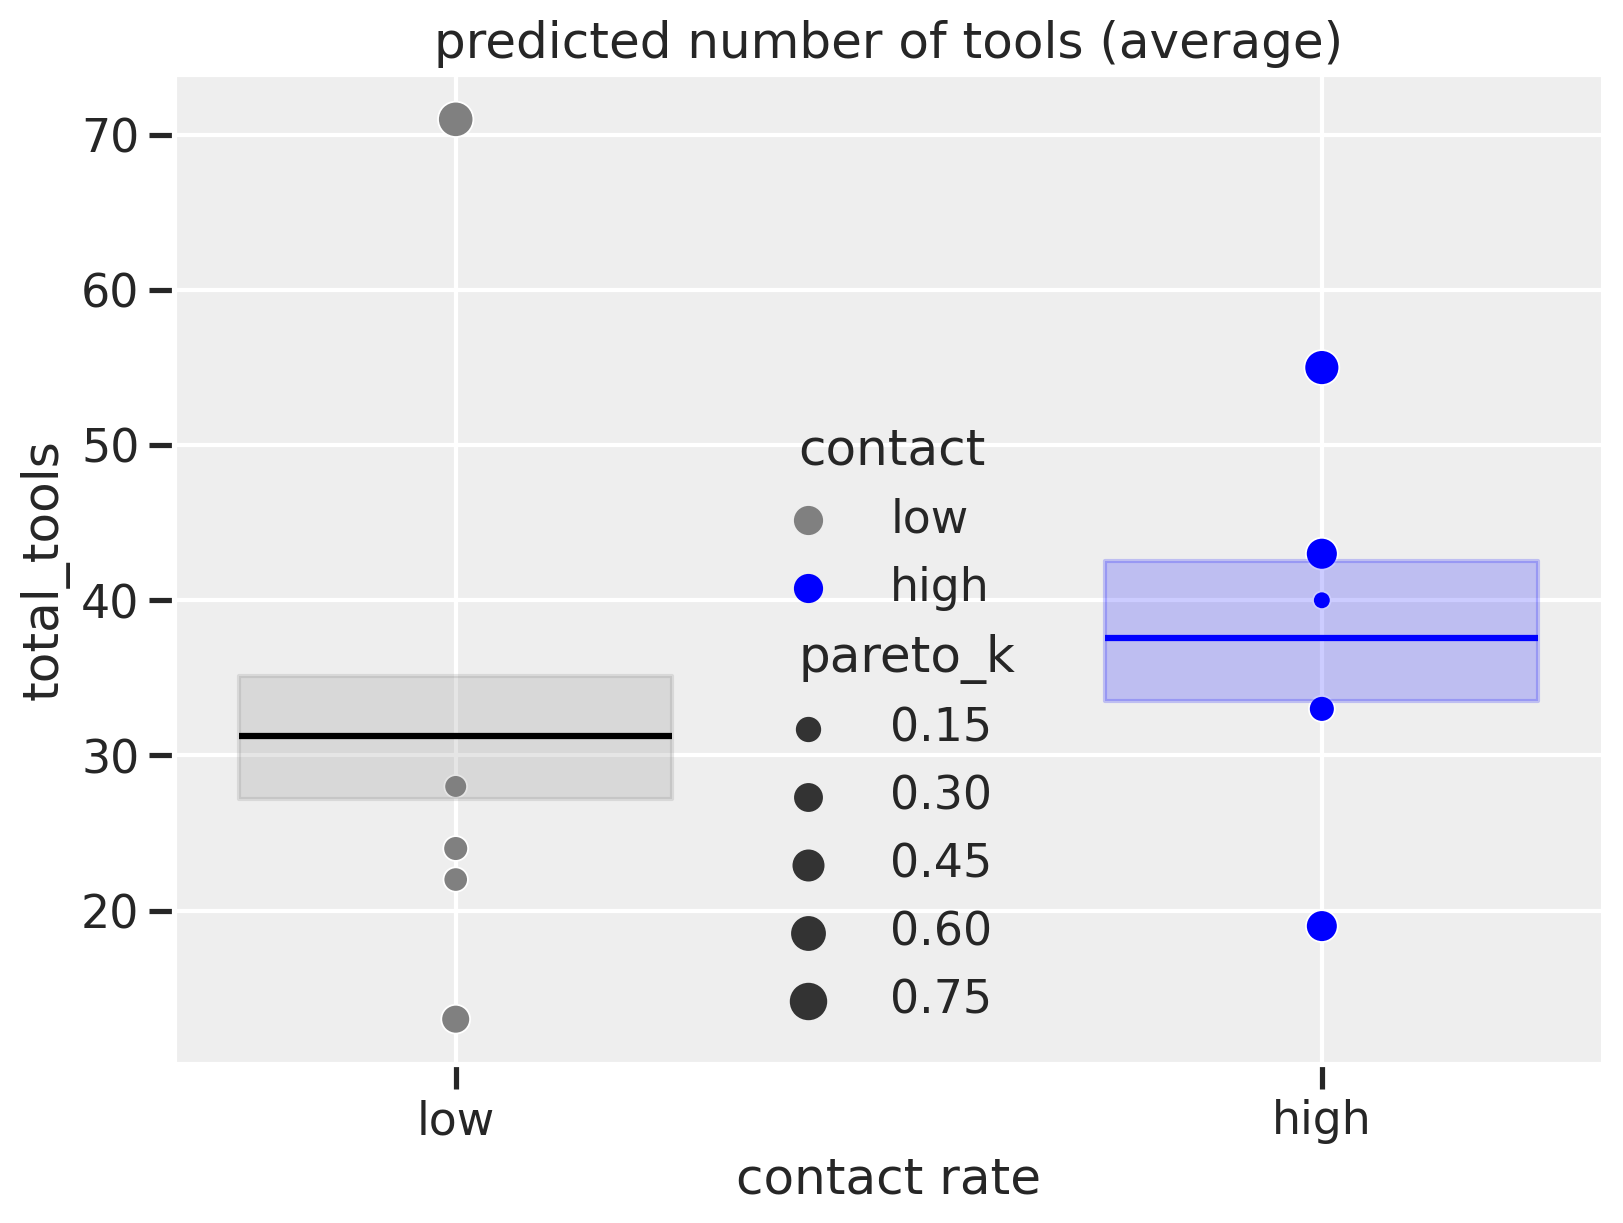

<IPython.core.display.Javascript object>

In [130]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharey=True)

# Observed values  -----------------------------------------
sns.scatterplot(
    data=df_kline,
    x="contact_id",
    y="total_tools",
    hue="contact",
    palette=["gray", "blue"],
    size="pareto_k",
    ax=ax1,
)

# Low contact ---------
# Mean value
ax1.hlines(y=df_t2_preds.loc[0, "avg_tools"], xmin=-0.25, xmax=0.25, color="black")

# HDI value
hdi_low, hdi_high = az.hdi(np.array(df_t2_preds.loc[0, :]))
ax1.fill_between(x=[-0.25, 0.25], y1=hdi_low, y2=hdi_high, color="gray", alpha=0.2)

# High contact ---------
# Mean value
ax1.hlines(y=df_t2_preds.loc[1, "avg_tools"], xmin=0.75, xmax=1.25, color="blue")

# HDI value
hdi_low, hdi_high = az.hdi(np.array(df_t2_preds.loc[1, :]))
ax1.fill_between(x=[0.75, 1.25], y1=hdi_low, y2=hdi_high, color="blue", alpha=0.2)

# Plot formatting
ax1.set_xticks([0, 1])
ax1.set_xticklabels(["low", "high"])
ax1.set_xlabel("contact rate")
ax1.set_title("predicted number of tools (average)")

# Next

- Add exposure and offset to Poisson
- Try other problems

Appendix: Environment and system parameters

In [3]:
%watermark -n -u -v -iv -w

Last updated: Wed May 26 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

scipy     : 1.6.0
pandas    : 1.2.1
arviz     : 0.11.1
json      : 2.0.9
matplotlib: 3.3.4
pymc3     : 3.11.0
seaborn   : 0.11.1
numpy     : 1.20.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>